In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import numpy as np 
import copy
import gym 

# rendering gym env
from IPython import display
import matplotlib
%matplotlib inline

In [3]:
env = gym.make('MontezumaRevenge-v0')

/home/brennan/anaconda2/envs/py3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
env.action_space, env.observation_space

(Discrete(18), Box(210, 160, 3))

## PPO Implementation

In [5]:
def Network(input_tensor, output_size, scope, fsize, conv_depth, n_hidden_dense=0, activation=tf.tanh, output_activation=None):
        with tf.variable_scope(scope):
            x = input_tensor
            # Convolutions
            for _ in range(conv_depth):
                x = tf.layers.conv2d(x, fsize, (3, 3), activation='relu')
                x = tf.layers.conv2d(x, fsize, (3, 3), strides=(2, 2))
            
            # Dense Layers
            x = tf.layers.flatten(x)
            for _ in range(n_hidden_dense):
                x = tf.layers.dense(x, fsize, activation=activation)
            y = tf.layers.dense(x, output_size, activation=output_activation)
        return y

In [6]:
class Policy(object):
    def __init__(self, sess, graph_args, adv_args):
        self.sess = sess
        self.ob_dim = graph_args['ob_dim']
        self.act_dim = graph_args['act_dim']
        clip_range = graph_args['clip_range']
        # conv operations params
        conv_depth = graph_args['conv_depth']
        filter_size = graph_args['filter_size']
        
        self.learning_rate = graph_args['learning_rate']
        self.num_target_updates = graph_args['num_target_updates']
        self.num_grad_steps_per_target_update = graph_args['num_grad_steps_per_target_update']
        
        self.gamma = adv_args['gamma']
        
        self.obs, self.act, self.adv, self.old_logprob = self.define_placeholders()
        
        # policy / actor evaluation
        self.policy_distrib = Network(self.obs, self.act_dim, 'policy', filter_size, conv_depth)
        self.greedy_action = tf.argmax(self.policy_distrib, axis=1)
        self.logprob = self.get_logprob(self.policy_distrib, self.act)
        
        # importance sampling
        ratio = tf.exp(self.logprob - self.old_logprob)
        clipped_ratio = tf.clip_by_value(ratio, 1.0-clip_range, 1.0+clip_range)        
        self.actor_loss = -1 * tf.reduce_mean(tf.minimum(ratio*self.adv, clipped_ratio*self.adv))
        self.actor_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss)
        
        # critic definition
        self.v_pred = tf.squeeze(Network(self.obs, 1, 'critic', filter_size, conv_depth, n_hidden_dense=2))
        self.v_target = tf.placeholder(shape=(None,), name='v_target', dtype=tf.float32)
        self.critic_loss = tf.losses.mean_squared_error(self.v_target, self.v_pred)
        # minimize with respect to correct variables HERE
        self.critic_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.critic_loss)
        
    def define_placeholders(self):
        obs = tf.placeholder(shape=((None,) + (self.ob_dim)), name='obs', dtype=tf.float32)
        act = tf.placeholder(shape=(None,), name='act', dtype=tf.int32)
        adv = tf.placeholder(shape=(None,), name='adv', dtype=tf.float32)
        logprob = tf.placeholder(shape=(None,), name='logprob', dtype=tf.float32)
        return obs, act, adv, logprob
    
    def get_logprob(self, policy_distribution, actions):
        action_enc = tf.one_hot(actions, depth=self.act_dim)
        logprob = -1 * tf.nn.softmax_cross_entropy_with_logits_v2(logits=policy_distribution, labels=action_enc)
        return logprob
        
    def get_best_action(self, observation):
        act = sess.run(self.greedy_action, feed_dict={
            self.obs: [observation]
        })[0]
        return act
    
    def estimate_adv(self, obs, rew, nxt_obs, dones):
        # V(s) & V(s')
        v_obs = self.sess.run(self.v_pred, feed_dict={self.obs: obs})
        v_nxt_obs = self.sess.run(self.v_pred, feed_dict={self.obs: nxt_obs})
        # y = r + gamma * V(s')
        y_obs = rew + (1 - dones) * self.gamma * v_nxt_obs
        # Adv(s) = y - V(s)
        adv = y_obs - v_obs
        # Normalize advantages
        adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-8)
        return adv
    
    def train_actor(self, obs, act, logprob, adv):
        self.sess.run(self.actor_update_op, feed_dict={
            self.obs: obs,
            self.act: act,
            self.adv: adv,
            self.old_logprob: logprob
        })
        
    def train_critic(self, obs, nxt_obs, rew, dones):
        for i in range(self.num_grad_steps_per_target_update * self.num_target_updates):
            if i % self.num_grad_steps_per_target_update == 0:
                v_pred = self.sess.run(self.v_pred, feed_dict={self.obs: nxt_obs})
                y = rew + self.gamma * v_pred * (1 - dones)
                
            _, loss = self.sess.run([self.critic_update_op, self.critic_loss],
                                    feed_dict={self.obs: obs, self.v_target: y})

In [7]:
class ReplayBuffer(object):
    def __init__(self):
        self.obs = []
        self.acts = []
        self.rewards = []
        self.nxt_obs = []
        self.dones = []
        self.logprobs = []
    
    def record(self, obs, act, rew, nxt_ob, done):
        self.obs.append(obs)
        self.acts.append(act)
        self.rewards.append(rew)
        self.nxt_obs.append(nxt_ob)
        self.dones.append(done)
        
    def get_actions(self):
        return np.asarray(self.obs), np.asarray(self.acts)
    
    def set_logprobs(self, logprobs):
        self.logprobs += list(logprobs)
        assert len(self.logprobs) == len(self.obs), 'logprobs MUST == self.obs'
        
    def merge(self, logprobs, obs, acts, rews, nxt_obs, dones):
        self.obs += obs
        self.acts += acts
        self.rewards += rews
        self.nxt_obs += nxt_obs
        self.dones += dones
        self.logprobs += list(logprobs)
    
    def export(self):
        return self.obs, self.acts, self.rewards, self.nxt_obs, self.dones
    
    def get_samples(self, indices):
        return (
            np.asarray(self.obs)[indices],
            np.asarray(self.acts)[indices],
            np.asarray(self.rewards)[indices],
            np.asarray(self.nxt_obs)[indices],
            np.asarray(self.dones)[indices],
            np.asarray(self.logprobs)[indices]
        )
    
    def flush(self):
        self.obs = []
        self.acts = []
        self.rewards = []
        self.nxt_obs = []
        self.dones = []
        self.logprobs = []
    
    def __len__(self):
        return len(self.obs)
        
class MasterBuffer(object):
    def __init__(self):
        self.master_replay = ReplayBuffer()
        self.temp_replay = ReplayBuffer()
    
    def record(self, *args):
        self.temp_replay.record(*args)
        
    def get_actions(self):
        return self.temp_replay.get_actions()
    
    def get_obs(self):
        return np.asarray(self.master_replay.obs)
    
    def set_logprobs(self, logprobs):
        temp_data = self.temp_replay.export()
        self.master_replay.merge(logprobs, *temp_data)
    
    def get_batch(self, batch_size):
        indices = np.random.randint(0, len(self.master_replay), batch_size)
        return self.master_replay.get_samples(indices)
    
    ## Density Sampling Start ##
    # credit to hw5
    def get_density_batch(self, states, batch_size):
        if len(self.master_replay) >= 2*len(states):
            positives, negatives = self.sample_idxs_replay(states, batch_size)
        else:
            positives, negatives = self.sample_idxs(states, batch_size)
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))], axis=0)
        return positives, negatives, labels
    
    def sample_idxs(self, states, batch_size):
        states = copy.deepcopy(states)
        data_size = len(states)
        pos_idxs = np.random.randint(data_size, size=batch_size)
        continue_sampling = True
        while continue_sampling:
            neg_idxs = np.random.randint(data_size, size=batch_size)
            if np.all(pos_idxs != neg_idxs):
                continue_sampling = False
        positives = np.concatenate([states[pos_idxs], states[pos_idxs]], axis=0)
        negatives = np.concatenate([states[pos_idxs], states[neg_idxs]], axis=0)
        return positives, negatives

    def sample_idxs_replay(self, states, batch_size):
        states = copy.deepcopy(states)
        data_size = len(states)
        pos_idxs = np.random.randint(data_size, size=batch_size)
        neg_idxs = np.random.randint(data_size, len(self.master_replay), size=batch_size)
        
        buffer_states = self.get_obs()
        positives = np.concatenate([states[pos_idxs], states[pos_idxs]], axis=0)
        negatives = np.concatenate([states[pos_idxs], buffer_states[neg_idxs]], axis=0)
        return positives, negatives
    ## Density Sampling End ##
    
    def get_temp_reward_info(self):
        rewards = np.asarray(self.temp_replay.rewards)
        return np.sum(rewards), np.std(rewards)
        
    def flush_temp(self):
        self.temp_replay.flush()
    
    def flush(self):
        self.temp_replay.flush()
        self.master_replay.flush()

In [8]:
class Logger(object):
    def __init__(self):
        self.tag = None
        self.totalr = []
        self.std_reward = []
        
        self.tags = []
        self.results = []
        
    def set_tag(self, tag):
        self.tag = tag
        
    def log(self, totalr, std):
        self.totalr.append(totalr)
        self.std_reward.append(std)
        
    def package_results(self):
        # store
        self.tags.append(self.tag)
        self.results.append([self.totalr, self.std_reward])
    
    def flush(self):
        self.totalr = []
        self.std_reward = []

Simple Actor Critic Test On Cart-Pole

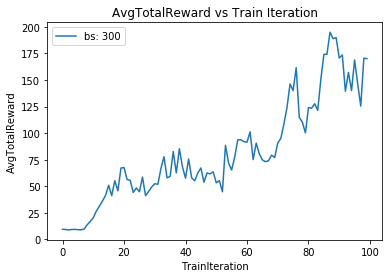

In [23]:
# for results in logger.results:
#     totalr, stdr = results[0], results[1]
#     plt.plot(totalr)
# plt.title('AvgTotalReward vs Train Iteration')
# plt.xlabel('TrainIteration')
# plt.ylabel('AvgTotalReward')
# plt.legend(logger.tags, loc='upper left')
# plt.show()

## Density Estimation

In [10]:
class DensityModel(object):
    def __init__(self, sess, graph_args):
        # un packing
        self.sess = sess
        self.ob_dim = graph_args['ob_dim']
        self.learning_rate = graph_args['learning_rate']
        self.z_size = graph_args['z_size']
        self.kl_weight = graph_args['kl_weight']
        # network operations params
        self.hid_size = graph_args['hid_size']
        self.n_hidden = graph_args['n_hidden']
        
        self.state1, self.state2 = self.define_placeholders()
        # q(z_1 | s_1), q(z_2 | s_2), p(z), p(y | z)
        self.encoder1, self.encoder2, self.prior, self.discriminator = self.forward_pass(self.state1, self.state2)
        self.discrim_target = tf.placeholder(shape=[None, 1], name="discrim_target", dtype=tf.float32)

        self.log_likelihood = tf.squeeze(self.discriminator.log_prob(self.discrim_target), axis=1)
        self.likelihood = tf.squeeze(self.discriminator.prob(self.discrim_target), axis=1)
        
        self.kl = self.encoder1.kl_divergence(self.prior) + self.encoder2.kl_divergence(self.prior)

        assert len(self.log_likelihood.shape) == len(self.likelihood.shape) == len(self.kl.shape) == 1
        
        self.elbo = tf.reduce_mean(self.log_likelihood - self.kl_weight * self.kl)
        self.update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.elbo)

    def define_placeholders(self):
        state1 = tf.placeholder(shape=((None,) + (self.ob_dim)), name="s1", dtype=tf.float32)
        state2 = tf.placeholder(shape=((None,) + (self.ob_dim)), name="s2", dtype=tf.float32)
        return state1, state2

    #Network(input_tensor, output_size, scope, fsize, conv_depth, n_hidden_dense=0, activation=tf.tanh, output_activation=None):
    def make_encoder(self, state, z_size, scope):
        """ Encodes the given state to z_size => create guass. distribution for q(z | s)
        """
        # conv operations
        z_mean = Network(state, z_size, scope, self.hid_size, conv_depth=self.n_hidden)
        z_logstd = tf.get_variable("logstd", shape=(z_size,)) 
        return tfp.distributions.MultivariateNormalDiag(loc=z_mean, scale_diag=tf.exp(z_logstd))

    def make_prior(self, z_size):
        """ Create Prior to map states too => p(z), we will use a normal guass distrib
        """
        prior_mean = tf.zeros((z_size,))
        prior_logstd = tf.zeros((z_size,))
        return tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=tf.exp(prior_logstd))

    def make_discriminator(self, z, output_size, scope, n_layers, hid_size):
        """ Predict D(z = [z1, z2]) => p(y | z)
        """
        logit = Network(z, output_size, scope, hid_size, conv_depth=0, n_hidden_dense=n_layers)
        return tfp.distributions.Bernoulli(logit)

    def forward_pass(self, state1, state2):
        # Reuse
        make_encoder1 = tf.make_template('encoder1', self.make_encoder)
        make_encoder2 = tf.make_template('encoder2', self.make_encoder)
        make_discriminator = tf.make_template('decoder', self.make_discriminator)

        # Encoder
        encoder1 = make_encoder1(state1, self.z_size, 'z1')
        encoder2 = make_encoder2(state2, self.z_size, 'z2')

        # Prior
        prior = self.make_prior(self.z_size)

        # Sampled Latent (some noise)
        self.z1 = encoder1.sample()
        z2 = encoder2.sample()
        z = tf.concat([self.z1, z2], axis=1)

        # Discriminator
        discriminator = make_discriminator(z, 1, 'discriminator', self.n_hidden, self.hid_size)
        return encoder1, encoder2, prior, discriminator

    def update(self, state1, state2, target):
        _, ll, kl, elbo = self.sess.run([self.update_op, self.log_likelihood, self.kl, self.elbo], feed_dict={
            self.state1: state1,
            self.state2: state2,
            self.discrim_target: target
        })
        return ll, kl, elbo
    
    def get_encoding(self, state):
        """Assuming only encode a single state at a time
        We will call this to use in our state dynamics fcn
        """
        return self.sess.run(self.z1, feed_dict={
            self.state1: [state]
        })[0]

    def get_likelihood(self, state1, state2):
        bs, _, _, _ = state1.shape
        target = np.zeros((bs, 1))
        for i, (s1, s2) in enumerate(zip(state1, state2)):
            if s1.all() == s2.all(): target[i] = [1]

        likelihood = self.sess.run(self.likelihood, feed_dict={
            self.state1: state1,
            self.state2: state2,
            self.discrim_target: target
        })
        return likelihood

    def get_prob(self, state):
        likelihood = self.get_likelihood(state, state)
        # avoid divide by 0 and log(0)
        likelihood = np.clip(np.squeeze(likelihood), 1e-5, 1-1e-5)
        prob = (1 - likelihood) / likelihood
        return prob
    
    def modify_reward(self, state, rewards):
        probs = self.get_prob(state)
        bonus = -np.log(probs)
        return rewards + 1e-3 * bonus

In [ ]:
class Agent(object):
    def __init__(self, sess, env, policy, density, replay_buffer, logger):
        self.sess = sess
        self.env = env
        self.policy = policy
        self.density = density
        self.replay_buffer = replay_buffer
        self.logger = logger
        
    def sample_env(self, num_samples):
        obs = self.env.reset()
        i = 0
        while True:
            act = self.choose_action(obs)
            nxt_ob, rew, done, _ = env.step(act)
            
            replay_buffer.record(obs, act, rew, nxt_ob, done)
            obs = nxt_ob if not done else env.reset()
            i+=1
            if i == num_samples - 1: break
        
        # get logprobs of taking actions w.r.t current policy
        obs, actions = replay_buffer.get_actions()
        logprobs = sess.run(policy.logprob, feed_dict={
            policy.obs: obs,
            policy.act: actions
        })
        replay_buffer.set_logprobs(logprobs)
        replay_buffer.flush_temp()
        
    def choose_action(self, obs):
        # Greedy action for now
        return self.policy.get_best_action(obs)
            
    def train(self, batch_size):
        obs, acts, rewards, nxt_obs, dones, logprobs = self.replay_buffer.get_batch(batch_size)
        # inject exploration bonus
        rewards = self.density.modify_reward(obs, rewards)

        # train actor
        adv = policy.estimate_adv(obs, rewards, nxt_obs, dones)
        self.policy.train_actor(obs, acts, logprobs, adv)
        
        # train critic
        self.policy.train_critic(obs, nxt_obs, rewards, dones)
        
        # train density model
        s1, s2, target = self.replay_buffer.get_density_batch(obs, batch_size)
        self.density.update(s1, s2, target)
    
    def test(self, num_tests, render=True, max_steps=1, title=''):
        obs = self.env.reset()
        plt.title(title)
        img = plt.imshow(self.env.render(mode='rgb_array'))
        i, step = 0, 0
        try:
            while num_tests > i:
                if render:
                    img.set_data(env.render(mode='rgb_array')) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                act = self.policy.get_best_action(obs)
                nxt_ob, rew, done, _ = env.step(act)
                replay_buffer.record(obs, act, rew, nxt_ob, done)
                obs = nxt_ob
                if done or step > max_steps:
                    obs = env.reset()
                    i += 1
                    step = 0
                step += 1
        finally:
            self.env.close()
            
        totalr, stdr = replay_buffer.get_temp_reward_info()
        logger.log(totalr / i, stdr)

KeyboardInterrupt: 

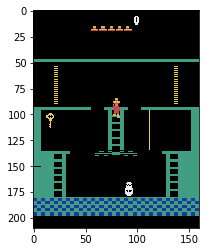

In [18]:
# test density fcn 
env = gym.make('MontezumaRevenge-v0')

tf.reset_default_graph()
tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1)
# tf_config.gpu_options.allow_growth = True
with tf.Session(config=tf_config) as sess:
    # defaults taken from homework
    d_graph_args = {
        'ob_dim': env.observation_space.shape,
        'learning_rate': 5e-3,
        'z_size': 32,
        'kl_weight': 1e-2,
        'conv_depth': 5,
        'hid_size': 32,
        'n_hidden': 4
    }
    p_graph_args = {
        'ob_dim': env.observation_space.shape,
        'act_dim': env.action_space.n,
        'clip_range': 0.2,
        'conv_depth': 5,
        'filter_size': 32,
        'learning_rate': 5e-3,
        'num_target_updates': 10,
        'num_grad_steps_per_target_update': 10
    }
    adv_args = {
        'gamma': 0.9999999
    }

    # models
    policy = Policy(sess, p_graph_args, adv_args)
    density_model = DensityModel(sess, d_graph_args)
    # utils
    replay_buffer = MasterBuffer()
    logger = Logger()
    
    # agent which will do all the work
    agent = Agent(sess, env, policy, density_model, replay_buffer, logger)
    
    # init variables
    sess.run(tf.global_variables_initializer())
    
    n_iter = 100
    num_samples = 100
    batch_sizes = [64]
    render_n = 10
    
    print('starting to train...')
    for bs in batch_sizes:
        logger.set_tag('bs: '+str(bs))
        replay_buffer.flush()
        
        for itr in range(n_iter):
            agent.sample_env(num_samples)
            agent.train(batch_size=bs)
            if itr % render_n == 0:
                agent.test(1, render=True, title='Iteration:'+str(itr))
            else:
                agent.test(10)
        print('iteration complete...')
        logger.package_results()
        logger.flush()

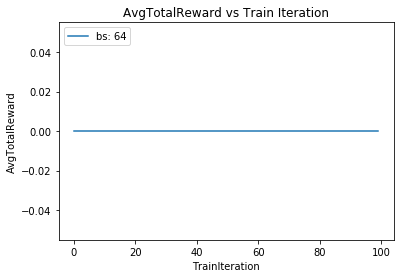

In [14]:
for results in logger.results:
    totalr, stdr = results[0], results[1]
    plt.plot(totalr)
plt.title('AvgTotalReward vs Train Iteration')
plt.xlabel('TrainIteration')
plt.ylabel('AvgTotalReward')
plt.legend(logger.tags, loc='upper left')
plt.show()

# TODO
- transport code to GPU environment to test density function
- split density training into seperate function <b>later</b>